In [1]:
import os
import re
import numpy as np
import textwrap
import torch
from sklearn.metrics import mean_squared_error
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt

In [2]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [4]:
device = "cuda:1"

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [6]:
checkpoint_path = "/auto/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
checkpoint_path

'/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/'

In [7]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [8]:
def calculate_tanimoto_distance_similarity(smiles1, smiles2):
    # Convert SMILES strings to RDKit molecules
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    # Check if the molecules were successfully created
    if mol1 is None or mol2 is None:
        raise ValueError("Invalid SMILES representation")

    # Generate MACCS keys for the molecules
    keys1 = MACCSkeys.GenMACCSKeys(mol1)
    keys2 = MACCSkeys.GenMACCSKeys(mol2)

    # Calculate the Tanimoto similarity
    common_bits = sum(bit1 & bit2 for bit1, bit2 in zip(keys1, keys2))
    total_bits = sum(bit1 | bit2 for bit1, bit2 in zip(keys1, keys2))

    tanimoto_similarity = common_bits / total_bits
    tanimoto_distance = 1.0 - tanimoto_similarity  # Tanimoto distance ranges from 0 to 1
    return tanimoto_distance, tanimoto_similarity

In [22]:
lead = Chem.MolToSmiles(Chem.MolFromSmiles("Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C"), canonical=True)
lead

'Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C'

In [23]:
lead = Chem.MolToSmiles(Chem.MolFromSmiles("Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C"), kekuleSmiles=True)
lead

'CC1=CC=C(NC(=O)NC(C)C)C=C1NC(=O)NC(C)C'

In [10]:
mols_dist0 = ['COc1ccccc1NS(=O)(=O)c1ccc(NC(C)=O)cc1',
            'CC(=O)Oc1cc2oc(=O)cc(C)c2cc1OC(C)=O',
            'COc1ccc(Oc2coc3cc(OC(C)=O)ccc3c2=O)cc1',
            'COc1ccc(C(=O)OCC(=O)Nc2ccc(C)cc2)cc1OC',
            'COc1ccc(C(=O)OCC(=O)Nc2ccc(F)cc2)cc1OC',
            'COc1ccc(C(=O)OCC(=O)Nc2ccc(Cl)cc2)cc1OC',
            'COc1ccc(OC)c(-c2oc3ccccc3c(=O)c2O)c1',
            'O=S(=O)(NCc1ccc(F)cc1F)c1ccc(F)cc1F',
            'CC1(O)CCC2C3CCC4=C(CCC(=O)C4)C3CCC21C',
            'NS(=O)(=O)c1cc(C(=O)Nc2ccccc2Cl)ccc1F',
            'CC(=O)Oc1ccc2c(C)cc(=O)oc2c1OC(C)=O',
            'Nc1ccc(S(=O)(=O)Nc2ccc(Cl)c(Cl)c2)cc1',
            'COC(=O)c1ccc(NC(=O)C(C)Oc2ccccc2OC)cc1',
            'CC(=O)Nc1ccc(S(=O)(=O)NCc2ccccc2Cl)cc1',
            'COc1cc2oc(=O)cc(C)c2c(OC)c1OC(C)=O',
            'COc1cccc(Oc2coc3cc(OC(C)=O)ccc3c2=O)c1',
            'COC(=O)c1cccc(NC(=O)COc2ccc(OC)cc2)c1C',
            'Clc1ccc(-c2cnn3c(-c4ccncc4)ccnc23)cc1',
            'COc1ccc(C=Cc2cc(OC)c(OC)c(OC)c2)cc1O',
            'COc1ccc(C(O)c2cc(OC)c(OC)c(OC)c2)cc1',
            'COc1ccc(C(=O)OCC(=O)Nc2cccc(Cl)c2)cc1OC',
            'COc1cccc(OC)c1C(=O)OCC(=O)Nc1cccc(Cl)c1',
            'COc1ccccc1NC(=O)C(C)OC(=O)c1ccc(F)cc1',
            'COc1cccc(C(=O)OC(C)C(=O)Nc2ccccc2OC)c1',
            'COc1ccc2oc(-c3ccccc3OC)c(O)c(=O)c2c1']

In [21]:
mols_dist0_PC = [
    'CC(=O)NC1=CC=C(C=C1)S(=O)(=O)NC2=CC=CC=C2OC',
    'CC1=CC(=O)OC2=CC(=C(C=C12)OC(=O)C)OC(=O)C',
    'CC(=O)OC1=CC2=C(C=C1)C(=O)C(=CO2)OC3=CC=C(C=C3)OC',
    'CC1=CC=C(C=C1)NC(=O)COC(=O)C2=CC(=C(C=C2)OC)OC',
    'COC1=C(C=C(C=C1)C(=O)OCC(=O)NC2=CC=C(C=C2)F)OC',
    'COC1=C(C=C(C=C1)C(=O)OCC(=O)NC2=CC=C(C=C2)Cl)OC',
    'COC1=CC(=C(C=C1)OC)C2=C(C(=O)C3=CC=CC=C3O2)O',
    'C1=CC(=C(C=C1F)F)CNS(=O)(=O)C2=C(C=C(C=C2)F)F',
    'CC12CCC3C(C1CCC2(C)O)CCC4=C3CCC(=O)C4',
    'C1=CC=C(C(=C1)NC(=O)C2=CC(=C(C=C2)F)S(=O)(=O)N)Cl',
    'CC1=CC(=O)OC2=C1C=CC(=C2OC(=O)C)OC(=O)C',
    'C1=CC(=CC=C1N)S(=O)(=O)NC2=CC(=C(C=C2)Cl)Cl',
    'CC(C(=O)NC1=CC=C(C=C1)C(=O)OC)OC2=CC=CC=C2OC',
    'CC(C(=O)NC1=CC=C(C=C1)C(=O)OC)OC2=CC=CC=C2OC',
    'CC1=CC(=O)OC2=CC(=C(C(=C12)OC)OC(=O)C)OC',
    'CC(=O)OC1=CC2=C(C=C1)C(=O)C(=CO2)OC3=CC=CC(=C3)OC',
    'CC1=C(C=CC=C1NC(=O)COC2=CC=C(C=C2)OC)C(=O)OC',
    'C1=CC(=CC=C1C2=C3N=CC=C(N3N=C2)C4=CC=NC=C4)Cl',
    'COC1=C(C=C(C=C1)C=CC2=CC(=C(C(=C2)OC)OC)OC)O',
    'COC1=CC=C(C=C1)C(C2=CC(=C(C(=C2)OC)OC)OC)O',
    'COC1=C(C=C(C=C1)C(=O)OCC(=O)NC2=CC(=CC=C2)Cl)OC',
    'COC1=C(C(=CC=C1)OC)C(=O)OCC(=O)NC2=CC(=CC=C2)Cl',
    'CC(C(=O)NC1=CC=CC=C1OC)OC(=O)C2=CC=C(C=C2)F',
    'CC(C(=O)NC1=CC=CC=C1OC)OC(=O)C2=CC(=CC=C2)OC',
    'COC1=CC2=C(C=C1)OC(=C(C2=O)O)C3=CC=CC=C3OC',
]

In [11]:
mols_dist03 = ['Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C',
              'Cc1ccc(CC(=O)NCCS(=O)c2ccc(C)cc2)cc1',
              'Cc1cccc(CC(=O)NCCS(=O)c2ccc(Cl)cc2)c1',
              'Cc1ccccc1SCC(=O)Nc1ccc(S(C)(=O)=O)cc1',
              'O=C(CSc1ncnc2sccc12)c1c[nH]c2ccccc12',
              'CCOc1ccccc1NC(=O)c1ccc(NS(=O)(=O)CC)cc1',
              'CCc1nnsc1C(=O)Nc1sc2c(c1C(N)=O)CCC2',
              'O=C(CS(=O)(=O)c1ccccc1)Nc1ccc2sccc2c1',
              'Cc1ccc(S(=O)(=O)CCC(=O)Nc2ccccc2F)cc1',
              'Cc1cc(OS(C)(=O)=O)nc2c1cnn2C(C)C',
              'CS(=O)c1ccc(C(=O)Nc2ccc3c(c2)CCC3)cc1',
              'O=C(CCS(=O)(=O)c1ccc(Cl)cc1)Nc1cccnc1',
              'O=C(CSc1ccc(Cl)cc1)NCc1ccc2c(c1)OCCO2',
              'Cc1c(NC(=O)C2CC2)cccc1C(=O)NCC(C)C',
              'CCC(C)C(=O)Nc1cccc(C(=O)NCC(C)C)c1C',
              'O=C(Nc1cccc2cn[nH]c12)c1cc(C2CC2)on1',
              'CCn1nnc2cc(C(=O)NCc3c[nH]nc3C)ccc21']

In [12]:
mols_dist03_PC = [
    'CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C',
    'CC1=CC=C(C=C1)CC(=O)NCCS(=O)C2=CC=C(C=C2)C',
    'CC1=CC(=CC=C1)CC(=O)NCCS(=O)C2=CC=C(C=C2)Cl',
    'CC1=CC=C(C=C1)CC(=O)NCCS(=O)C2=CC=C(C=C2)C',
    'CC1=CC=CC=C1SCC(=O)NC2=CC=C(C=C2)S(=O)(=O)C',
    'C1=CC=C2C(=C1)C(=CN2)C(=O)CSC3=NC=NC4=C3C=CS4',
    'CCOC1=CC=CC=C1NC(=O)C2=CC=C(C=C2)NS(=O)(=O)CC',
    'CCC1=C(SN=N1)C(=O)NC2=C(C3=C(S2)CCC3)C(=O)N',
    'C1=CC=C(C=C1)S(=O)(=O)CC(=O)NC2=CC3=C(C=C2)SC=C3',
    'CC1=CC=C(C=C1)S(=O)(=O)CCC(=O)NC2=CC=CC=C2F',
    'CC1=CC(=NC2=C1C=NN2C(C)C)OS(=O)(=O)C',
    'CS(=O)C1=CC=C(C=C1)C(=O)NC2=CC3=C(CCC3)C=C2',
    'C1=CC(=CN=C1)NC(=O)CCS(=O)(=O)C2=CC=C(C=C2)Cl',
    'C1COC2=C(O1)C=CC(=C2)CNC(=O)CSC3=CC=C(C=C3)Cl',
    'C1CC1C2=CC(=NO2)C(=O)NC3=CC=CC4=C3NN=C4',
    'CCN1C2=C(C=C(C=C2)C(=O)NCC3=C(NN=C3)C)N=N1',
]

In [21]:
prompt = '[SIMILAR]Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C 0.9[/SIMILAR][START_SMILES]'
prompt = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
tokenizer.batch_decode(model.generate(prompt, max_length=300, eos_token_id=20))

['[SIMILAR]Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C 0.9[/SIMILAR][START_SMILES]C1C(NC(=O)NC(C(=O)N1)NC(=O)N)N[END_SMILES]']

In [29]:
calculate_tanimoto_distance_similarity("Cc1ccc(NC(=O)NC(C)C)cc1NC(=O)NC(C)C", "C1C(NC(=O)NC(C(=O)N1)NC(=O)N)N")

(0.5714285714285714, 0.42857142857142855)

In [55]:
prompt = '[SIMILAR]CC1=CC=C(NC(=O)NC(C)C)C=C1NC(=O)NC(C)C 0.2[/SIMILAR][START_SMILES]'
prompt = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
out = model.generate(prompt, max_length=300, eos_token_id=20)
tokenizer.batch_decode(out)

['[SIMILAR]CC1=CC=C(NC(=O)NC(C)C)C=C1NC(=O)NC(C)C 0.2[/SIMILAR][START_SMILES]CC(C)NC(=O)N(CCCN)CCCN[END_SMILES]']

In [33]:
calculate_tanimoto_distance_similarity("CC1=CC=C(NC(=O)NC(C)C)C=C1NC(=O)NC(C)C", "CC(C)NC(=O)N(CCCN)CCCN")

(0.6382978723404256, 0.3617021276595745)

In [28]:
def tanimoto_similarity(smiles_1, smiles_2):
    fgp1 = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles_1)))
    fgp2 = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles_2)))

    both = np.sum(fgp1 & fgp2)

    return both / (np.sum(fgp1) + np.sum(fgp2) - both)

In [43]:
generated_mols, target_sims, generated_sims = [],[],[]
invalids = 0
for mol in mols_dist03_PC:
    for tar_similarity in np.arange(0.1, 1.1, 0.1):
        # mol = Chem.MolToSmiles(Chem.MolFromSmiles(mol), kekuleSmiles=True)
        # mol = Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True)
        prompt = f'[SIMILAR]{mol} {tar_similarity:.2f}[/SIMILAR][START_SMILES]'
        print(prompt)
        prompt = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        out = model.generate(prompt, max_length=300, eos_token_id=20, do_sample=False)
        if 20 in out:
            for seq in out:
                decoded = tokenizer.decode(seq)
                # print(decoded)
                captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
                try:
                    gen_similarity = round(tanimoto_similarity(mol, captured_text), 2)
                    generated_mols.append(captured_text)
                    target_sims.append(tar_similarity)
                    generated_sims.append(gen_similarity)
                    print(tar_similarity, gen_similarity, captured_text)
                except Exception as e:
                    invalids += 1
                    print(e)
                    continue
            # print(tokenizer.decode(out[0]))
            invalids += 1

[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.10[/SIMILAR][START_SMILES]
0.1 1.0 CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.20[/SIMILAR][START_SMILES]
0.2 0.46 CC1=C(C=C(C=C1)NC(=O)NCC2CCN(CC2)C)N
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.30[/SIMILAR][START_SMILES]
0.30000000000000004 0.44 CC1=C(C=C(C=C1)NC(=O)N2CCN(CC2)C)N
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.40[/SIMILAR][START_SMILES]
0.4 0.81 CC1=C(C=C(C=C1)NC(=O)NCC(C)C)NC(=O)NCC(C)C
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.50[/SIMILAR][START_SMILES]
0.5 0.81 CC1=C(C=C(C=C1)NC(=O)NCC(C)C)NC(=O)NCC(C)C
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.60[/SIMILAR][START_SMILES]
0.6 0.83 CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NCC(C)C
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.70[/SIMILAR][START_SMILES]
0.7000000000000001 1.0 CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C
[SIMILAR]CC1=C(C=C(C=C1)NC(=O)NC(C)C)NC(=O)NC(C)C 0.80[/SIMILAR][START_SM

Text(0.5, 1.0, 'rmse=0.38, agg 15 mols dist > 0.3 to PC, PC representation, invalids=160')

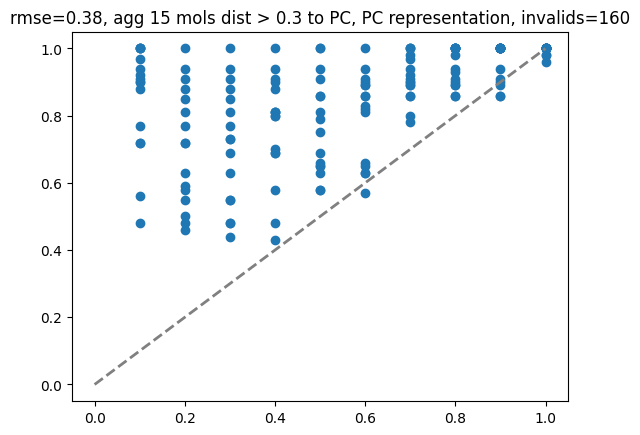

In [44]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 15 mols dist > 0.3 to PC, PC representation, {invalids=}')

Text(0.5, 1.0, 'rmse=0.34, agg 17 mols dist > 0.3 to PC, canonical=True, invalids=144')

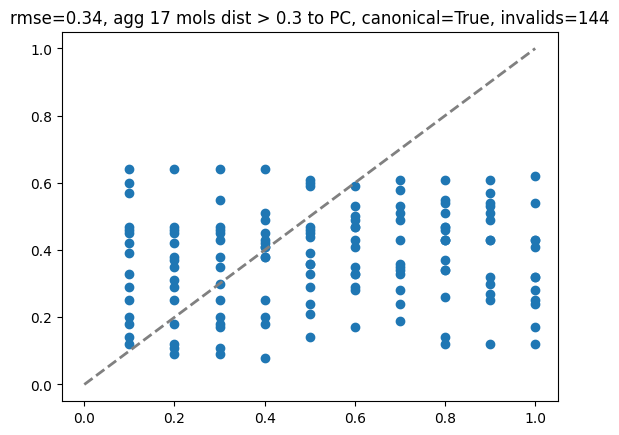

In [40]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 17 mols dist > 0.3 to PC, canonical=True, {invalids=}')

Text(0.5, 1.0, 'rmse=0.31, agg 17 mols dist > 0.3 to PC, kekuleSMILES=True, invalids=167')

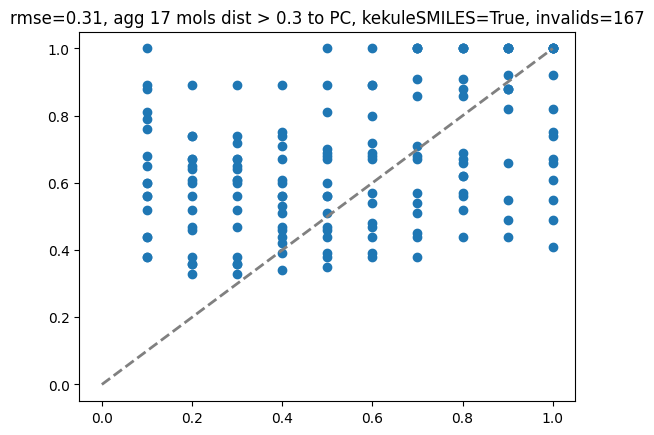

In [38]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 17 mols dist > 0.3 to PC, kekuleSMILES=True, {invalids=}')

Text(0.5, 1.0, 'rmse=0.28, agg 25 mols dist 0 to PC, canonical=True, invalids=164')

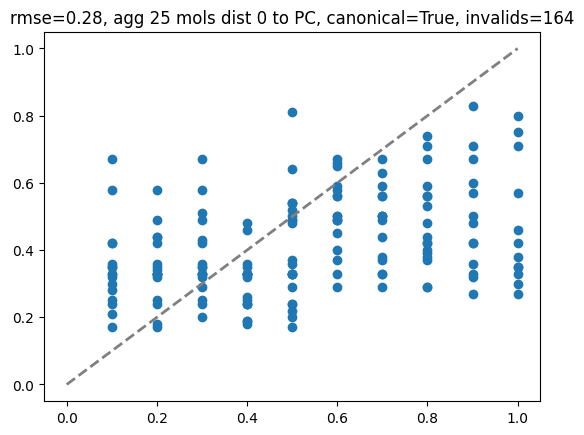

In [34]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 25 mols dist 0 to PC, canonical=True, {invalids=}')

Text(0.5, 1.0, 'rmse=0.29, agg 25 mols dist 0 to PC, kekuleSMILES=True, invalids=219')

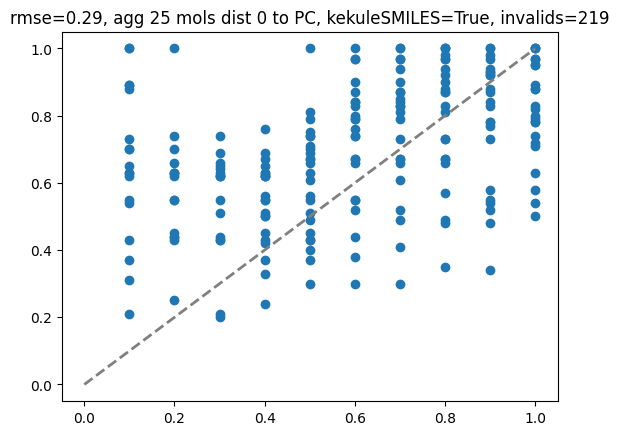

In [36]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 25 mols dist 0 to PC, kekuleSMILES=True, {invalids=}')

Text(0.5, 1.0, 'rmse=0.35, agg 25 mols dist 0 to PC, PC representation, invalids=223')

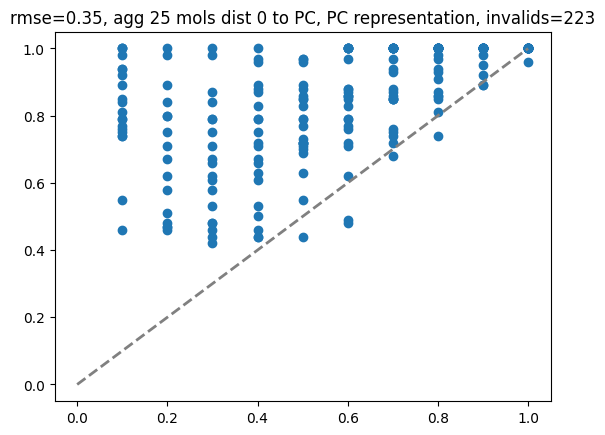

In [32]:
rmse = mean_squared_error(target_sims, generated_sims, squared=False)
plt.scatter(target_sims, generated_sims)
plt.plot((0,1), (0, 1.0), color='grey', linestyle='--', linewidth=2);
plt.title(f'{rmse=:.2f}, agg 25 mols dist 0 to PC, PC representation, {invalids=}')

In [111]:
mean_squared_error(target_sims, generated_sims, squared=True)

0.06406683937823834

In [110]:
generated_sims.__len__()

193